In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
billing = pd.read_csv("billing.csv") 
events = pd.read_csv("events.csv")
sessions = pd.read_csv("sessions.csv")
users = pd.read_csv('users.csv')

In [4]:
# Generate a per-user feature adoption matrix (binary 0/1 for each feature), then sum across features
PRODUCT_FEATURES = [
    'jira_board','jira_automation','team_invite','bitbucket_integration',
    'confluence_page','confluence_ai_assist','trello_export_csv'
]

# Create a pivot table: rows=user_id, columns=feature, values=1 if used, else 0
feature_usage = (
    events
        .groupby(['user_id','feature_name']).size()
        .unstack(fill_value=0)
        .reindex(columns=PRODUCT_FEATURES, fill_value=0)
)

# Convert counts to binary (0/1): used or not
feature_usage_binary = (feature_usage > 0).astype(int)

# Add a column for total features adopted
feature_usage_binary['feature_adoption_count'] = feature_usage_binary.sum(axis=1)

feature_usage_binary.head()

feature_name,jira_board,jira_automation,team_invite,bitbucket_integration,confluence_page,confluence_ai_assist,trello_export_csv,feature_adoption_count
user_id,,,,,,,,
0000093e-7258-43c0-b212-ea7212795ddf,1,0,0,0,0,0,0,1
0006fdbd-c35d-4c0d-a948-e8ee10f279d5,0,0,0,0,0,1,0,1
0007ee13-0c60-4865-9464-914b2df654df,1,1,1,0,0,0,0,3
000836d5-0777-4310-a8a5-5c857d2ea5e5,0,0,0,0,1,0,0,1
0008a782-5378-45a1-b332-10c73c4296ff,0,0,1,0,1,1,1,4


Features with highest adoption among retained and lowest among churned:
                       retained   churned      diff
team_invite            0.257466  0.163860  0.093606
jira_automation        0.405438  0.323177  0.082261
bitbucket_integration  0.238330  0.174828  0.063502
jira_board             0.560245  0.518724  0.041522
confluence_ai_assist   0.218386  0.178152  0.040234
trello_export_csv      0.137390  0.101374  0.036016
confluence_page        0.289608  0.273986  0.015621


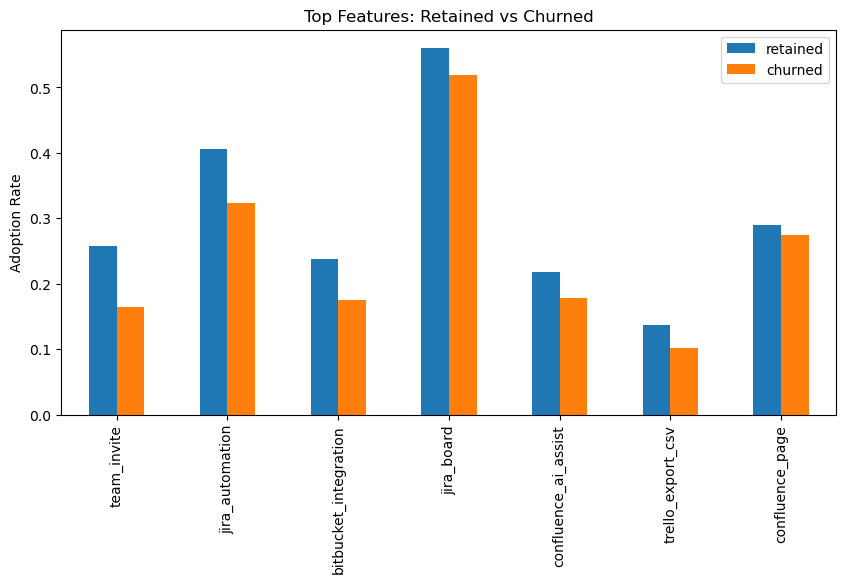

In [5]:
# Merge feature adoption with churn info
user_churn = users.set_index('user_id')[['churned_90d']]
adoption = feature_usage_binary.join(user_churn, how='inner')

# Calculate adoption rates for each feature by churn status
feature_cols = [c for c in feature_usage_binary.columns if c != 'feature_adoption_count']
adoption_rates = adoption.groupby('churned_90d')[feature_cols].mean().T
adoption_rates.columns = ['retained', 'churned']

# Find features with highest adoption among retained and lowest among churned
adoption_rates['diff'] = adoption_rates['retained'] - adoption_rates['churned']
adoption_rates_sorted = adoption_rates.sort_values('diff', ascending=False)

print("Features with highest adoption among retained and lowest among churned:")
print(adoption_rates_sorted)

# Optionally, plot the top features
adoption_rates_sorted[['retained', 'churned']].head(10).plot(kind='bar', figsize=(10,5), title='Top Features: Retained vs Churned')
plt.ylabel('Adoption Rate')
plt.show()


In [6]:
user_max_adoption = adoption[adoption['feature_adoption_count'] == adoption['feature_adoption_count'].max()]
user_highest_adoption = users[users['user_id'].isin(user_max_adoption.index)]

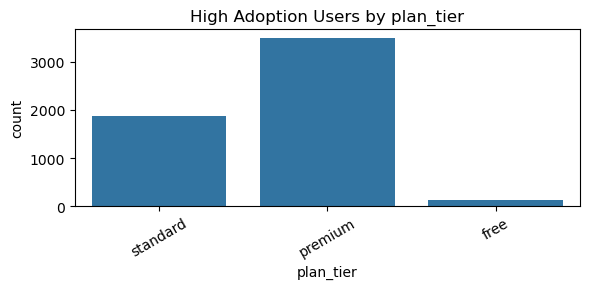

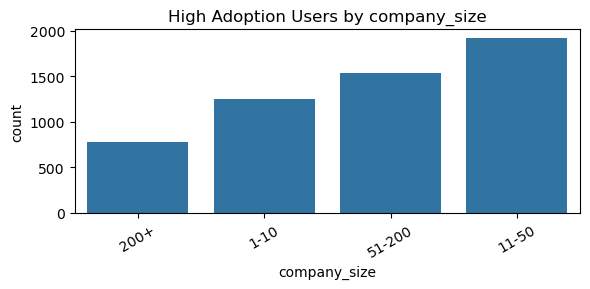

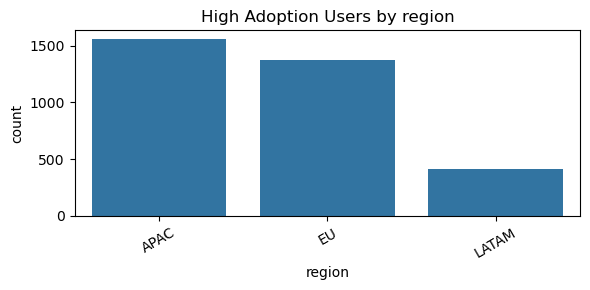

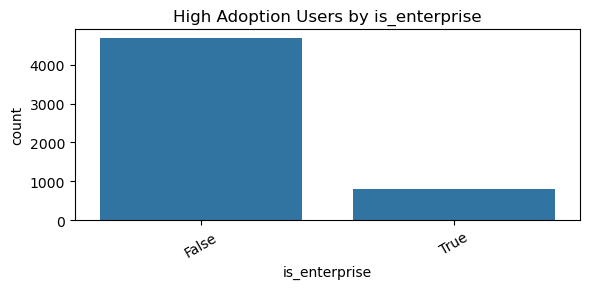

In [7]:
# Visualize characteristics of high adoption users
import matplotlib.pyplot as plt
import seaborn as sns

# Choose characteristics to plot
demo_cols = ['plan_tier', 'company_size', 'region', 'is_enterprise']

for col in demo_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(data=user_highest_adoption, x=col)
    plt.title(f'High Adoption Users by {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_42099/1734829909.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette='Set2')


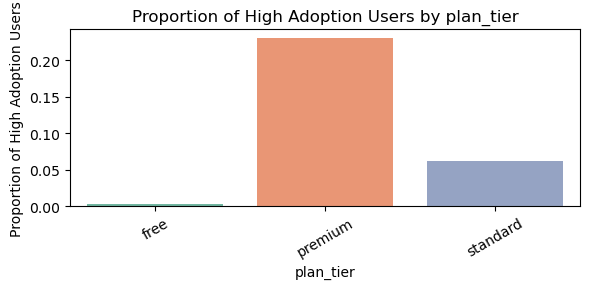

/tmp/ipykernel_42099/1734829909.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette='Set2')


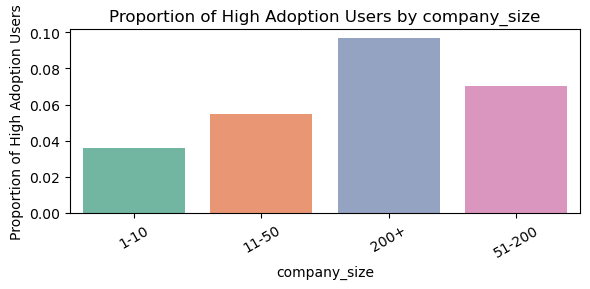

/tmp/ipykernel_42099/1734829909.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette='Set2')


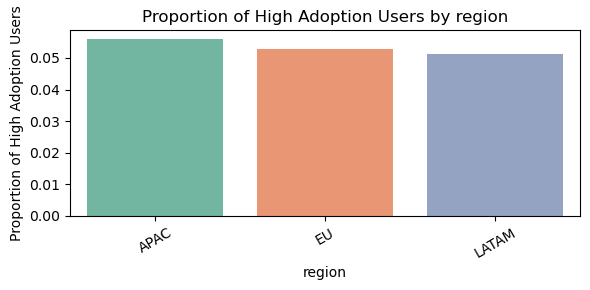

/tmp/ipykernel_42099/1734829909.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop.index, y=prop.values, palette='Set2')


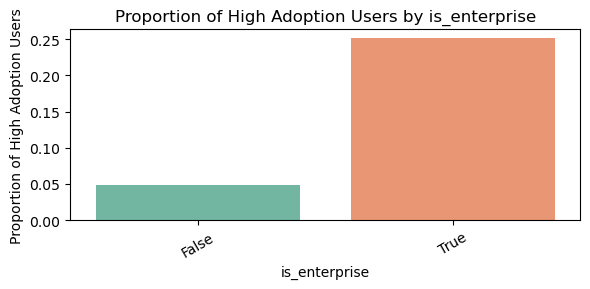

In [8]:
# Normalized proportion of high adoption users by category
for col in demo_cols:
    # Calculate proportion of high adoption users in each category
    total_per_cat = users[col].value_counts().sort_index()
    high_adopt_per_cat = user_highest_adoption[col].value_counts().sort_index()
    prop = (high_adopt_per_cat / total_per_cat).fillna(0)
    
    plt.figure(figsize=(6,3))
    sns.barplot(x=prop.index, y=prop.values, palette='Set2')
    plt.title(f'Proportion of High Adoption Users by {col}')
    plt.ylabel('Proportion of High Adoption Users')
    plt.xlabel(col)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [9]:
# Join users and adoption data set
feature_usage_binary.reset_index(inplace=True)
feature_usage_binary['user_id'].nunique() - users['user_id'].nunique()
adoption = feature_usage_binary.merge(users, on='user_id', how='inner')

In [10]:
adoption.groupby('industry')[PRODUCT_FEATURES].count()

,jira_board,jira_automation,team_invite,bitbucket_integration,confluence_page,confluence_ai_assist,trello_export_csv
industry,,,,,,,
education,5748,5748,5748,5748,5748,5748,5748
energy,5731,5731,5731,5731,5731,5731,5731
finance,5811,5811,5811,5811,5811,5811,5811
healthcare,5778,5778,5778,5778,5778,5778,5778
manufacturing,5806,5806,5806,5806,5806,5806,5806
media,5687,5687,5687,5687,5687,5687,5687
retail,5606,5606,5606,5606,5606,5606,5606
software,5713,5713,5713,5713,5713,5713,5713
telecom,5646,5646,5646,5646,5646,5646,5646


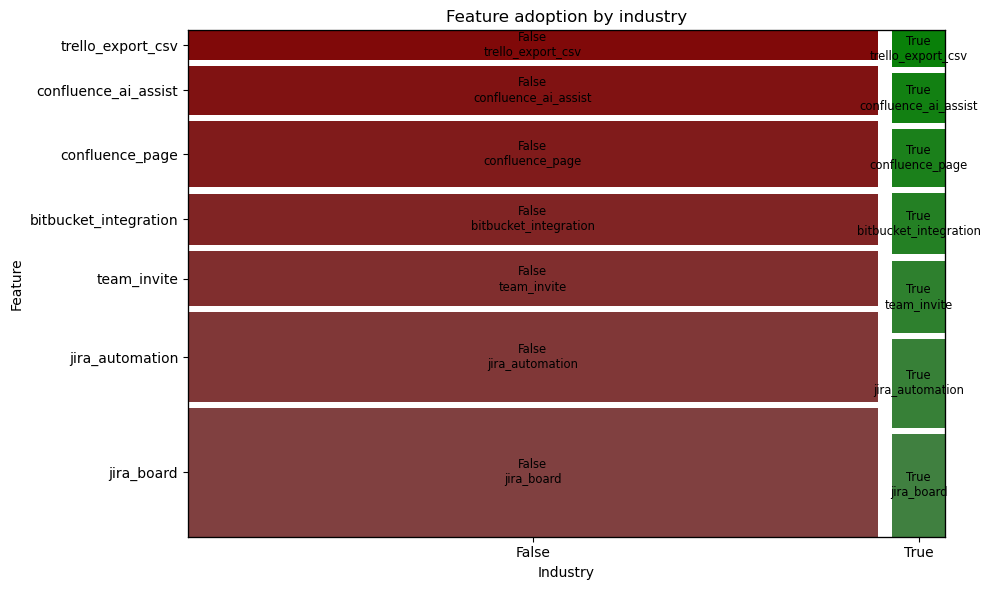

In [11]:
# If you haven't already:
# pip install statsmodels

import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# 1) Get adoption counts per (industry, feature)
#    Sum 0/1 columns → number of adopters
adoption_counts = (
    adoption
      .groupby('is_enterprise')[PRODUCT_FEATURES]
      .sum()                       # << use sum, not count
      .stack()                     # long form
      .rename('count')
      .reset_index()
      .rename(columns={'level_1': 'feature'})
)

# 2) Convert to the dict format mosaic() expects: {(industry, feature): count}
mosaic_data = {
    (row['is_enterprise'], row['feature']): int(row['count'])
    for _, row in adoption_counts.iterrows()
}

# 3) Plot the mosaic
fig, ax = plt.subplots(figsize=(10, 6))
mosaic(mosaic_data, ax=ax, title='Feature adoption by industry',gap=0.02)
ax.set_xlabel('Industry')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()


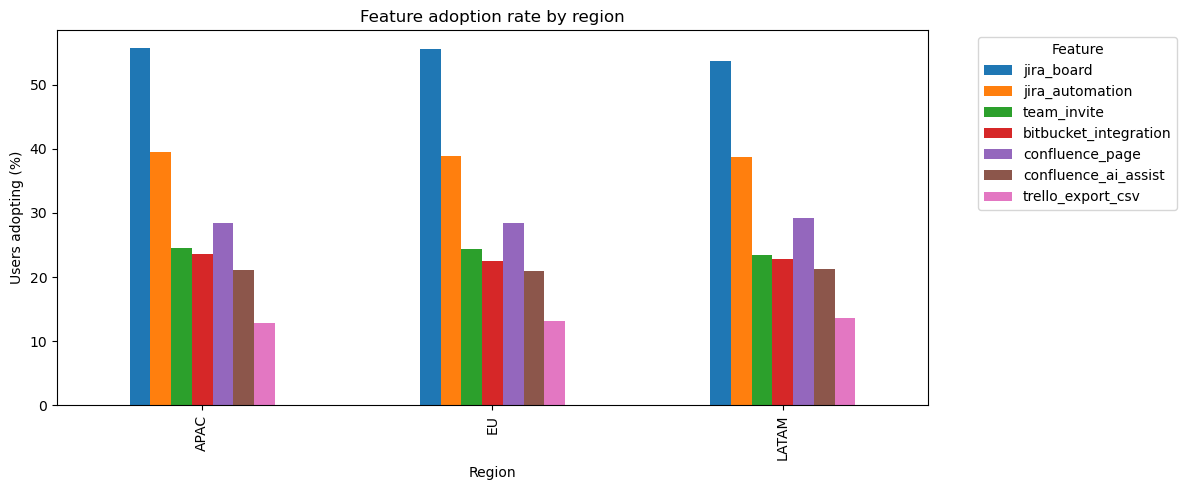

In [12]:
# adopters per region & feature (your code)
adoption_counts = adoption.groupby('region')[PRODUCT_FEATURES].sum()

# denominator: users per region (assumes one row per user in `adoption`)
users_per_region = adoption.groupby('region').size()

# adoption rate per region-feature
adoption_rate = adoption_counts.div(users_per_region, axis=0)  # 0..1
(adoption_rate * 100).plot(kind='bar', figsize=(12,5))
plt.title('Feature adoption rate by region')
plt.ylabel('Users adopting (%)')
plt.xlabel('Region')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_42099/3768503001.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='Set2')


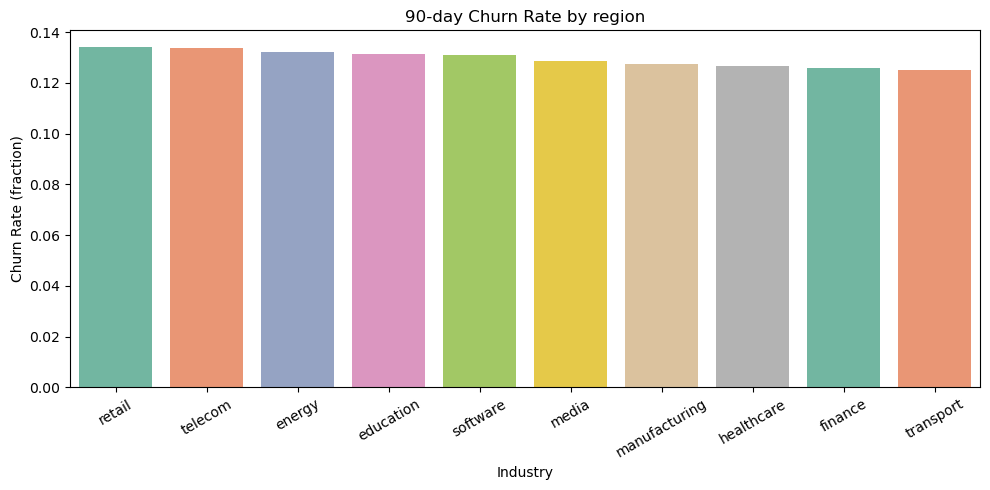

In [13]:
# Calculate churn rate per industry
churn_rate = users.groupby('industry')['churned_30d'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=churn_rate.index, y=churn_rate.values, palette='Set2')
plt.ylabel('Churn Rate (fraction)')
plt.xlabel('Industry')
plt.title('90-day Churn Rate by region')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

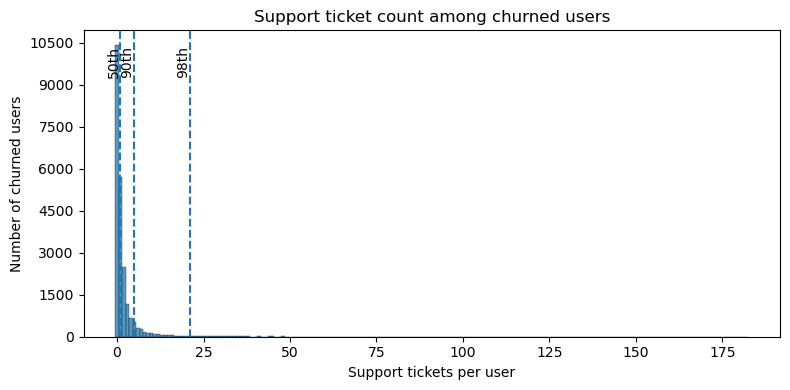

Share of churned users at/above threshold (21): 2.0%


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter

# 1) Churned users only
churned_ids = users.loc[users['churned_90d'].astype(bool), 'user_id']

# 2) Join to support tickets (aggregate if billing has multiple rows per user)
#    Change .sum() to .max()/.mean() as appropriate for your data model.
tickets_per_user = (
    billing[billing['user_id'].isin(churned_ids)]
        .groupby('user_id', as_index=False)['support_ticket_count']
        .sum()
)

# 3) Basic hygiene
tickets = tickets_per_user['support_ticket_count'].dropna()

# 4) Percentiles (within CHURNED users only)
p50 = tickets.quantile(0.50)
p90 = tickets.quantile(0.90)
p98 = tickets.quantile(0.98)

# 5) Plot: histogram for churned users’ ticket counts
plt.figure(figsize=(8,4))
ax = sns.histplot(tickets, bins=30, discrete=True)  # counts are integers; discrete=True spaces bars

# Percentile markers
for val, lab in [(p50, '50th'), (p90, '90th'), (p98, '98th')]:
    ax.axvline(val, linestyle='--')
    ax.text(val, ax.get_ylim()[1]*0.95, lab, ha='right', va='top', rotation=90)

ax.set_title('Support ticket count among churned users')
ax.set_xlabel('Support tickets per user')
ax.set_ylabel('Number of churned users')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# (Optional) quick proportion above a chosen threshold within churned users
threshold = p98  # or any business cutoff
share_high = (tickets >= threshold).mean()
print(f"Share of churned users at/above threshold ({threshold:.0f}): {share_high:.1%}")




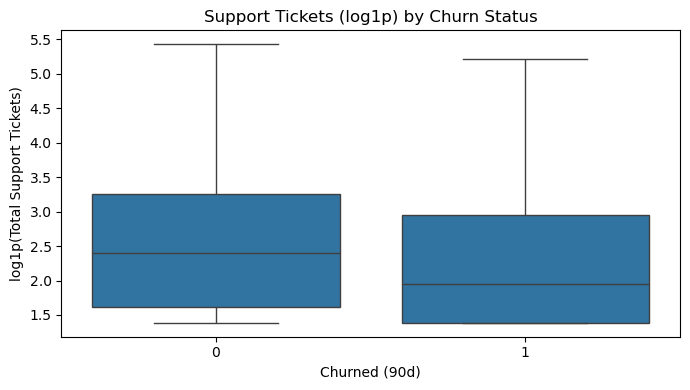

Raw counts:
                   mean  median  count
churned_90d                          
0            21.900303    10.0  11224
1            15.653502     6.0   1342 

Log1p scale (median back-transformed):
                  mean    median  count  median_backtransformed
churned_90d                                                   
0            2.558570  2.397895  11224                    10.0
1            2.269095  1.945910   1342                     6.0 

Mann-Whitney U test p-value (raw counts): 0.0000
Mann-Whitney U test p-value (log1p): 0.0000


In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Merge churn info with support ticket counts (aggregate if needed)
user_tickets = (
    billing[billing['support_ticket_count']>= 3].groupby('user_id')['support_ticket_count'].sum().reset_index()
    .merge(users[['user_id', 'churned_90d']], on='user_id', how='left')
)

# Log-transform: log1p handles zeros (log(1 + x))
user_tickets['support_ticket_count_log1p'] = np.log1p(user_tickets['support_ticket_count'])

# Boxplot on LOG scale values
plt.figure(figsize=(7,4))
sns.boxplot(
    data=user_tickets,
    x='churned_90d',
    y='support_ticket_count_log1p'
)
plt.title('Support Tickets (log1p) by Churn Status')
plt.xlabel('Churned (90d)')
plt.ylabel('log1p(Total Support Tickets)')
plt.tight_layout()
plt.show()

# Mean/median by group — raw
group_stats_raw = user_tickets.groupby('churned_90d')['support_ticket_count'].agg(['mean','median','count'])
print("Raw counts:\n", group_stats_raw, "\n")

# Mean/median by group — log scale (with back-transform of median for interpretability)
group_stats_log = user_tickets.groupby('churned_90d')['support_ticket_count_log1p'].agg(['mean','median','count'])
group_stats_log['median_backtransformed'] = np.expm1(group_stats_log['median'])
print("Log1p scale (median back-transformed):\n", group_stats_log, "\n")

# Statistical test (Mann-Whitney U). Rank-based → invariant to monotonic transforms like log1p.
from scipy.stats import mannwhitneyu
churned = user_tickets.loc[user_tickets['churned_90d'] == 1, 'support_ticket_count']
retained = user_tickets.loc[user_tickets['churned_90d'] == 0, 'support_ticket_count']
stat, pval = mannwhitneyu(churned, retained, alternative='two-sided')
print(f'Mann-Whitney U test p-value (raw counts): {pval:.4f}')

# Optional: sanity-check it’s the same on log1p (it should be)
stat2, pval2 = mannwhitneyu(
    np.log1p(churned), np.log1p(retained), alternative='two-sided'
)
print(f'Mann-Whitney U test p-value (log1p): {pval2:.4f}')


<Axes: xlabel='support_ticket_count_log1p', ylabel='Count'>

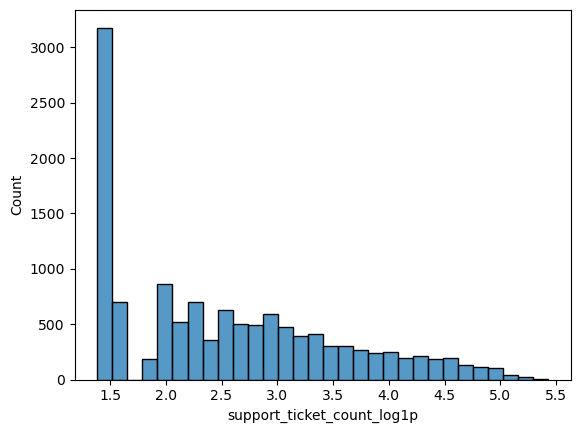

In [16]:
sns.histplot(data = user_tickets, x='support_ticket_count_log1p', bins=30)

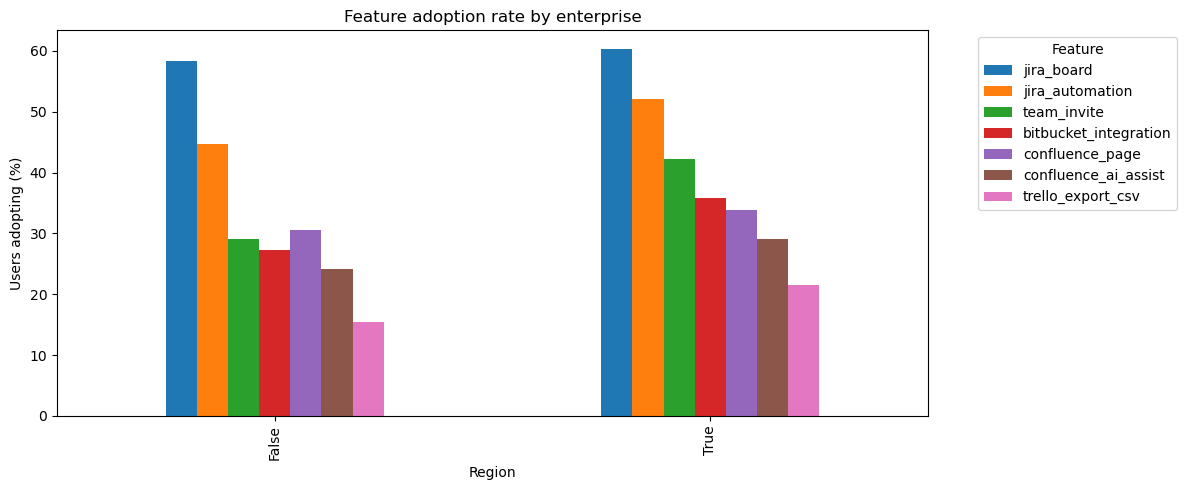

In [17]:
# adopters per region & feature (your code)
adoption_counts = adoption[adoption['plan_tier'] != 'free'].groupby('is_enterprise')[PRODUCT_FEATURES].sum()

# denominator: users per region (assumes one row per user in `adoption`)
users_per_region = adoption[adoption['plan_tier'] != 'free'].groupby('is_enterprise').size()

# adoption rate per region-feature
adoption_rate = adoption_counts.div(users_per_region, axis=0)  # 0..1
(adoption_rate * 100).plot(kind='bar', figsize=(12,5))
plt.title('Feature adoption rate by enterprise')
plt.ylabel('Users adopting (%)')
plt.xlabel('Region')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Axes: ylabel='is_enterprise-plan_tier'>

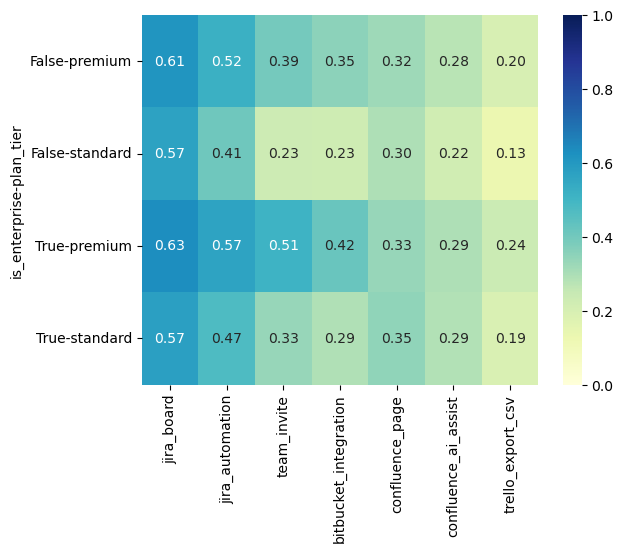

In [18]:
sns.heatmap(adoption[adoption['plan_tier'] != 'free'].groupby(['is_enterprise', 'plan_tier'])[PRODUCT_FEATURES].mean(),vmax= 1, vmin=0, annot=True, fmt=".2f", cmap="YlGnBu")


In [19]:
user_tickets = (
    billing.groupby('user_id')['support_ticket_count'].mean().reset_index()
    .merge(users[['user_id', 'churned_90d']], on='user_id', how='left')
)

user_tickets['support_ticket_count'].quantile(0.90)

np.float64(1.1666666666666667)

/tmp/ipykernel_42099/599886913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_tickets, x=col, palette = 'Set3')


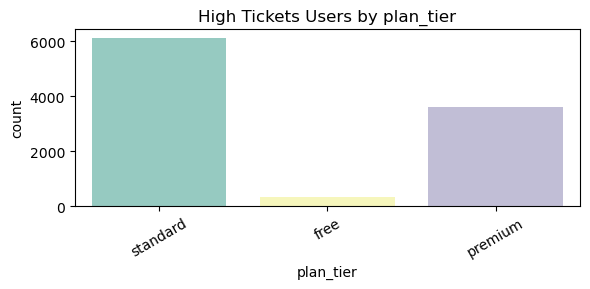

/tmp/ipykernel_42099/599886913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_tickets, x=col, palette = 'Set3')


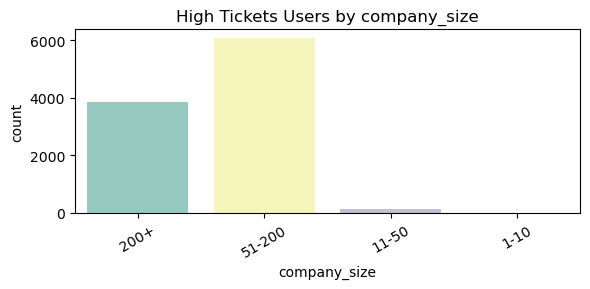

/tmp/ipykernel_42099/599886913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_tickets, x=col, palette = 'Set3')


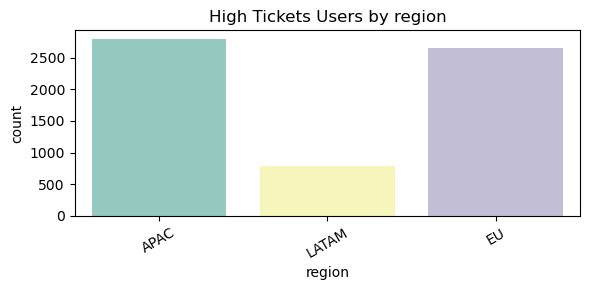

/tmp/ipykernel_42099/599886913.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_tickets, x=col, palette = 'Set3')


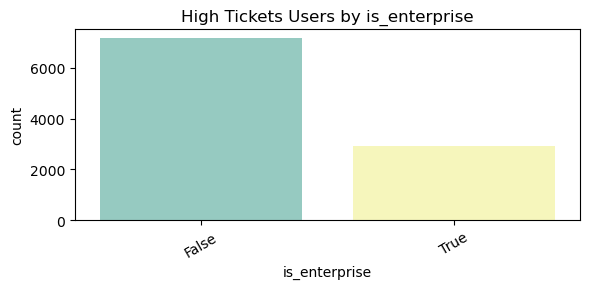

In [20]:
high_tickets = users[users['user_id'].isin(user_tickets[user_tickets['support_ticket_count'] >= 1.1666]['user_id'])]


# Choose characteristics to plot
demo_cols = ['plan_tier', 'company_size', 'region', 'is_enterprise']

for col in demo_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(data=high_tickets, x=col, palette = 'Set3')
    plt.title(f'High Tickets Users by {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


In [37]:
events[events['latency_ms'] >= 1000]

,event_id,user_id,session_id,ts,feature_name,action,duration_ms,latency_ms,success
48,e95cddea-afe0-4e1d-9ec3-ab8e7c3b0c47,c2cb519d-ac2b-4ca3-8b26-5903b1ff1117,920d1c8e-fc20-483a-bb38-6f5132a63a23,2024-02-22 13:27:59.413896311,jira_board,view,142,9400,1
62,23bdfb5c-0ff6-4a48-9393-2538703dff9b,a4ea3ea4-9428-4dae-80ee-f33c043dda21,9b2d946d-3fee-4a12-9d21-737db895f598,2025-01-20 18:04:49.307137655,confluence_ai_assist,complete,401,5225,1
76,0285680e-f544-43be-b06c-ee5894daa0a3,a44b8970-3fec-47df-b07e-467e7ae8349f,86fcae36-a4d8-4a8b-be4b-317b571b5be5,2024-05-17 14:00:03.713905099,jira_automation,complete,510,1042,0
114,013f229a-d253-4299-a74b-7dbe125157e0,f8e0a344-b14c-49a5-8168-3bb5b87188b8,fc9d73e2-2a23-48c9-980e-6c87f67ec66b,2025-07-04 14:52:20.038708163,bitbucket_integration,complete,1084,1885,1
180,11eadc63-93a0-4f19-9f59-87ca016745bd,5775eae2-87c9-4bb7-89d2-07cf73c00b30,abcb1c16-4090-4aef-ac92-067e2d6e16c5,2024-08-25 04:07:17.577986747,jira_automation,complete,727,1020,1
...,...,...,...,...,...,...,...,...,...
233837,53b55323-a8d8-4e44-8b0f-a4e76bc48dc9,15715420-2b3d-43d9-83be-7df3d0cc6217,6c66e452-3380-49c9-8ae5-199db22c3abf,2025-05-28 12:11:53.414750214,confluence_ai_assist,click,543,2988,1
234004,f2e1d91c-5ef1-4aaf-8ed8-5e05fc15be99,025f7e62-d694-4221-b831-578ffec5552c,d48f9d18-779d-4e67-82a7-3e113f2f2bd7,2025-05-01 22:19:24.953986732,confluence_ai_assist,click,343,1301,1
234018,64728b6e-0169-4d9a-997f-d69b2396f695,941cc10c-42cc-430e-9c21-8797b179f9f2,0e2ec5d5-d4aa-4098-8909-e517693369fc,2025-02-14 13:50:36.023138053,jira_automation,complete,2489,1057,1
234125,c38716cb-4ef2-4283-8a9e-68dc83b8a5f7,d92a5698-047f-4d33-ab3a-d2de0d3cb94d,f49cbe83-2f45-4315-a9df-b8ec126d3adc,2025-07-29 00:55:31.026725669,jira_board,click,1989,1063,1


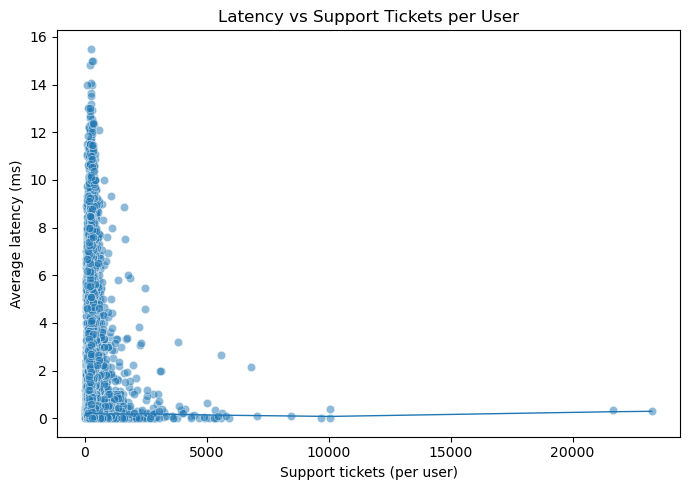

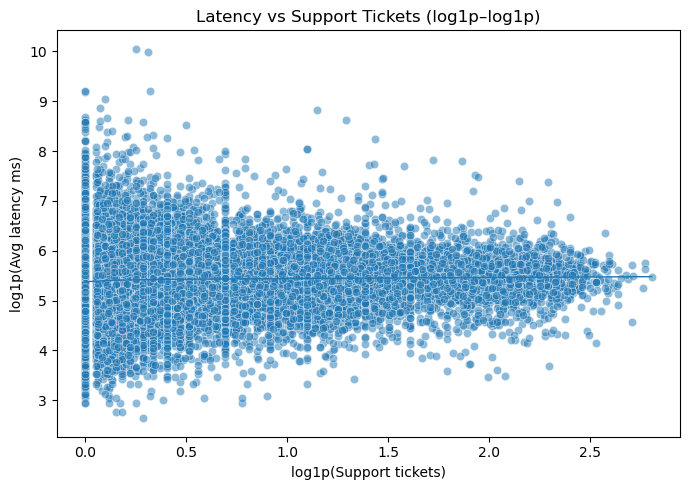

Spearman ρ = 0.05, p = 2.57e-32


In [50]:

# --- Per-user aggregates ---
# Avg latency per user (exclude jira_automation)
latency_per_user = (
    events.loc[events['feature_name'] != 'jira_automation']
          .groupby('user_id', as_index=False)['latency_ms']
          .mean()
          .rename(columns={'latency_ms': 'avg_latency_ms'})
)

# Support tickets per user
# Use .sum() if billing has multiple rows per user and you want total tickets;
# use .mean() if rows are time slices and you want average per period.
tickets_per_user = (
    billing.groupby('user_id', as_index=False)['support_ticket_count']
           .mean()   # <- swap to .mean() if that's your intended metric
)

# Merge
df = tickets_per_user.merge(latency_per_user, on='user_id', how='inner').dropna(subset=['avg_latency_ms'])

# (Optional) keep only "high-ticket" users like your original threshold
threshold = 1.1666
df_high = df[df['support_ticket_count'] >= threshold]

# --- Scatter (all users) ---
plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=df, y='support_ticket_count', x='avg_latency_ms', alpha=0.5)
sns.regplot(data=df, y='support_ticket_count', x='avg_latency_ms',
            scatter=False, lowess=True, line_kws={'linewidth':1})
ax.set_title('Latency vs Support Tickets per User')
ax.set_xlabel('Support tickets (per user)')
ax.set_ylabel('Average latency (ms)')
plt.tight_layout(); plt.show()

# --- Scatter with log1p transforms (handles zeros/heavy tails) ---
df['tickets_log1p'] = np.log1p(df['support_ticket_count'])
df['latency_log1p'] = np.log1p(df['avg_latency_ms'])

plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=df, x='tickets_log1p', y='latency_log1p', alpha=0.5)
sns.regplot(data=df, x='tickets_log1p', y='latency_log1p',
            scatter=False, lowess=True, line_kws={'linewidth':1})
ax.set_title('Latency vs Support Tickets (log1p–log1p)')
ax.set_xlabel('log1p(Support tickets)')
ax.set_ylabel('log1p(Avg latency ms)')
plt.tight_layout(); plt.show()

# --- Quick association metric ---
rho, p = spearmanr(df['support_ticket_count'], df['avg_latency_ms'], nan_policy='omit')
print(f"Spearman ρ = {rho:.2f}, p = {p:.2e}")

# If you specifically want to plot only high-ticket users:
# sns.scatterplot(data=df_high, x='support_ticket_count', y='avg_latency_ms', alpha=0.6)
